In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.lorenz96 import Lorenz96Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## Model

Periodic domain $u \in [0,L)$ and $N$ equally spaced grid-points $u_j = j \Delta$, $\Delta = \frac{L}{N}$, with system governed by ODEs

\begin{align}
  \frac{\mathrm{d} z_j}{\mathrm{d} t} = -\frac{z_{j\ominus 1} z_{j\oplus 1} - z_{j\ominus 2} z_{j\ominus 1}}{3 \Delta} - z_j + f
  \quad \forall j \in \{1 \dots N\}
\end{align}

with $\oplus$ and $\ominus$ indicating addition / subtraction modulo $N_x$ respectively. Model due to Lorenz (1996):

> Lorenz, Edward (1996). "Predictability – A problem partly solved". 
> Seminar on Predictability, Vol. I, ECMWF.

Here we use $\Delta = \frac{1}{3}$, $N = 40$, $f= 8$.

In [2]:
n_steps = 200
seed = 20171027
rng = np.random.RandomState(seed)
observation_func = lambda z, t: z
state_noise_std = 1.
obser_noise_std = 1.
model = Lorenz96Model(
    rng=rng, state_noise_std=state_noise_std, obser_noise_std=obser_noise_std,
    observation_func=observation_func)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

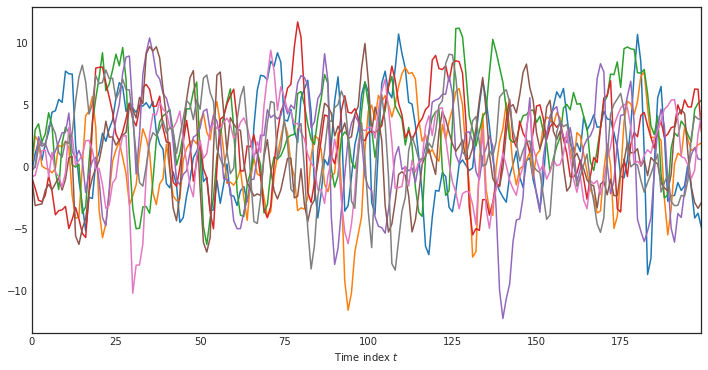

In [4]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[:, ::5])
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

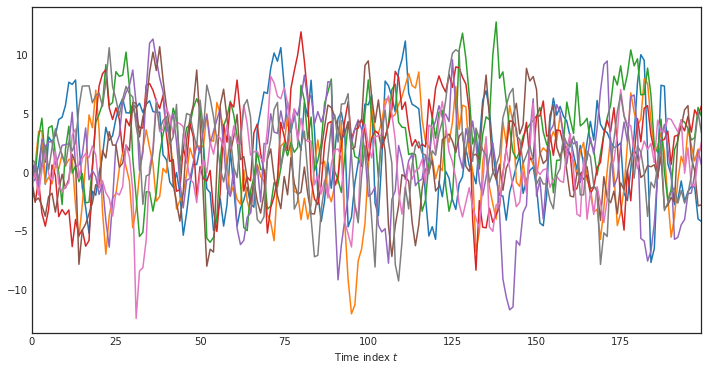

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference[:, ::5])
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

## Infer state from observations

### Ensemble Kalman filter (perturbed observations)

In [6]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [7]:
%%time
results_enkf = enkf.filter(x_reference, 1000)

CPU times: user 1min 23s, sys: 796 ms, total: 1min 24s
Wall time: 24.8 s


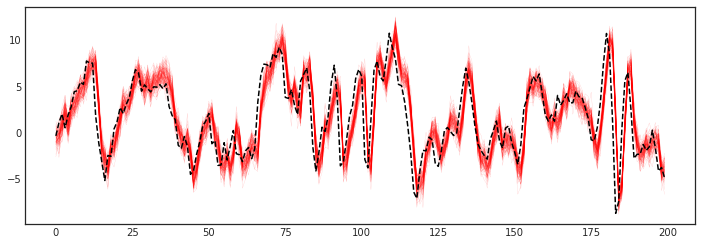

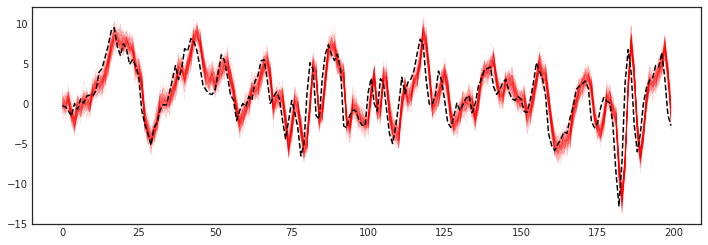

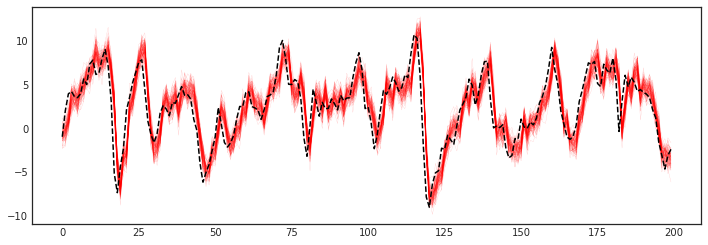

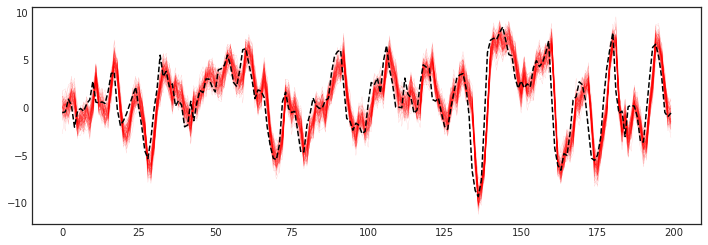

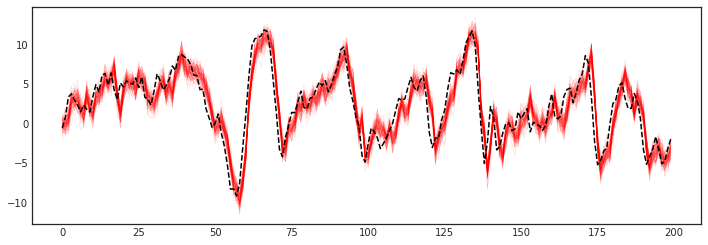

In [8]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_enkf['z_particles_seq'][:, ::10, i], 'r-', 
                lw=0.25, alpha=0.25, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Bootstrap particle filter

In [9]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [10]:
%%time
results_bspf = bspf.filter(x_reference, 100)

CPU times: user 8.23 s, sys: 88 ms, total: 8.32 s
Wall time: 2.72 s


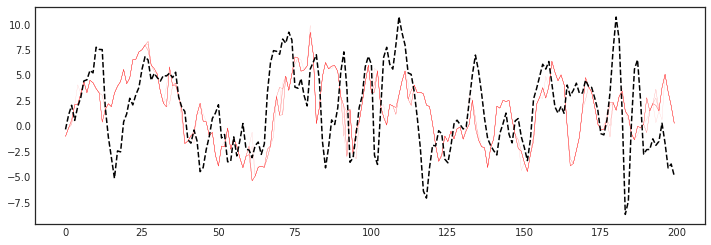

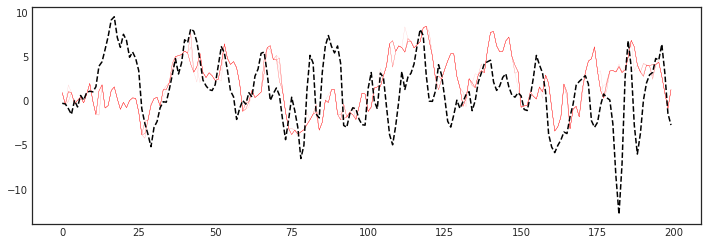

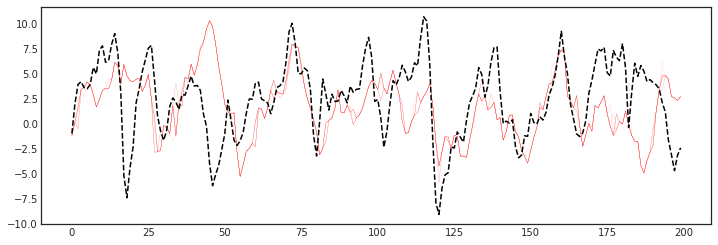

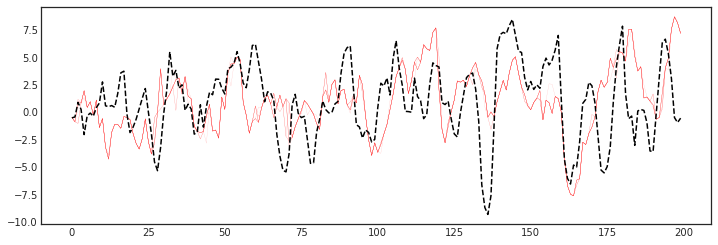

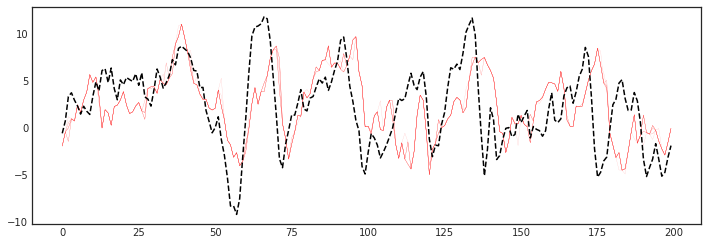

In [11]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_bspf['z_particles_seq'][:, ::10, i], 'r-', lw=0.25, alpha=0.25, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Ensemble transform particle filter

In [12]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [13]:
%%time
results_etpf = etpf.filter(x_reference, 1000)

CPU times: user 3min 42s, sys: 37 s, total: 4min 19s
Wall time: 2min


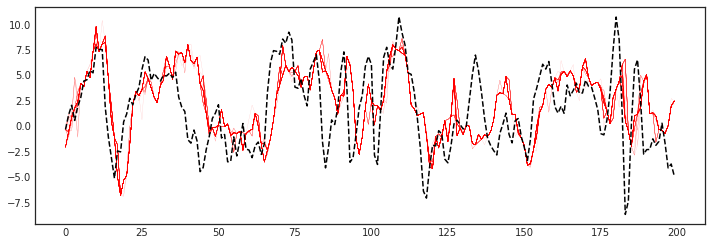

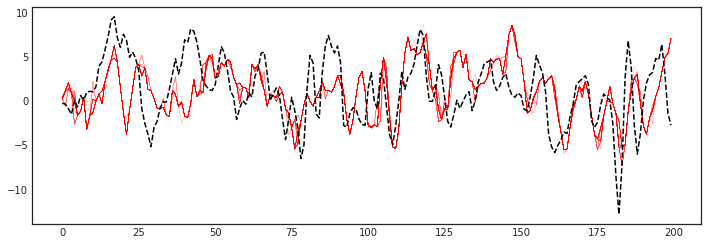

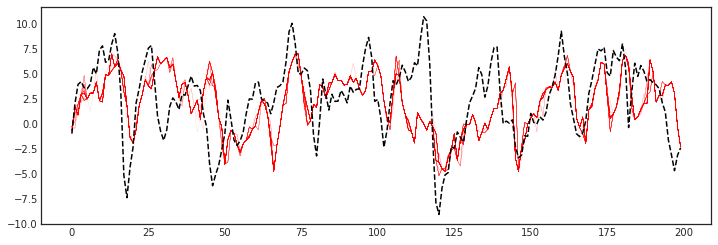

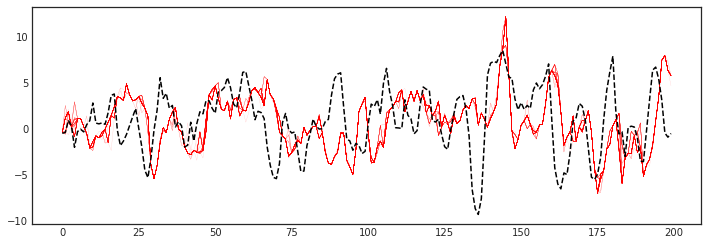

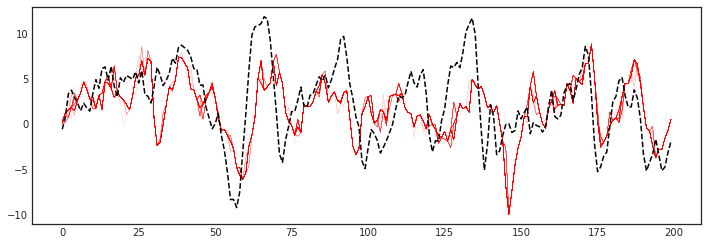

In [14]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_etpf['z_particles_seq'][:, ::10, i], 'r-', lw=0.25, alpha=0.25, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Visualise estimated means of filtering distribution

/home/matt/miniconda2/envs/dapy3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


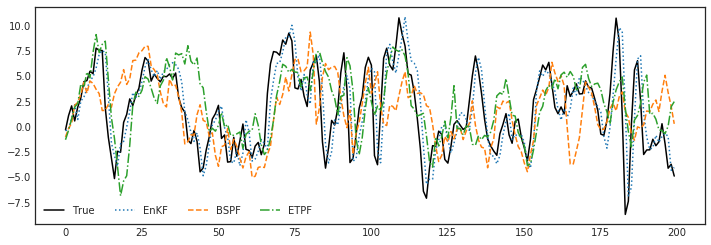

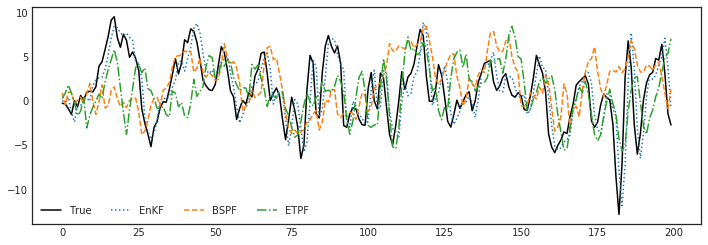

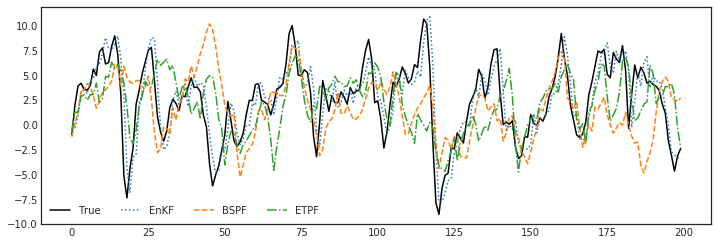

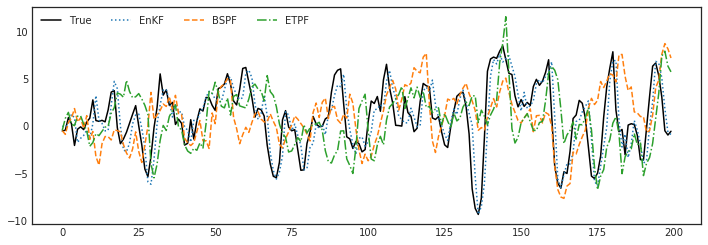

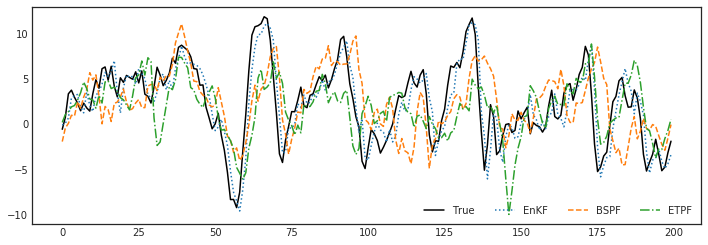

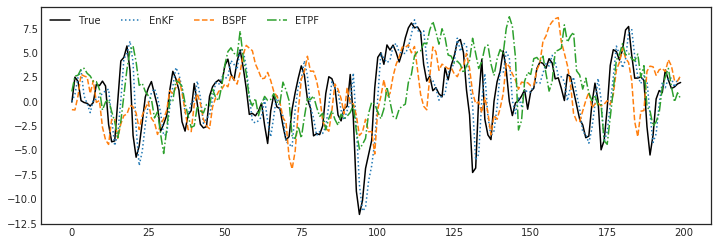

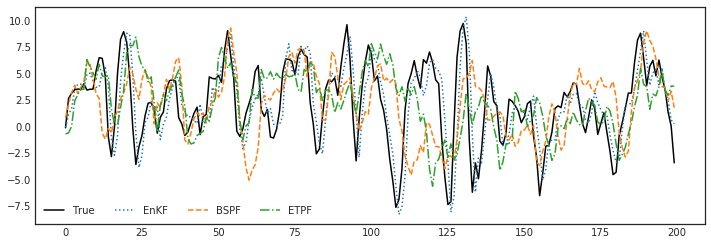

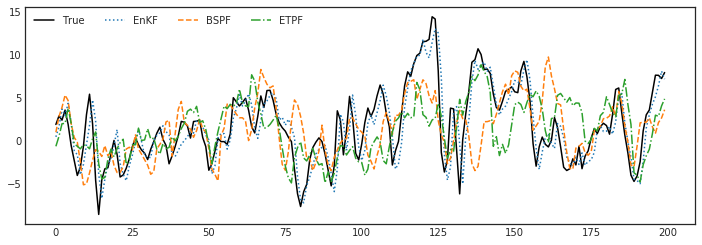

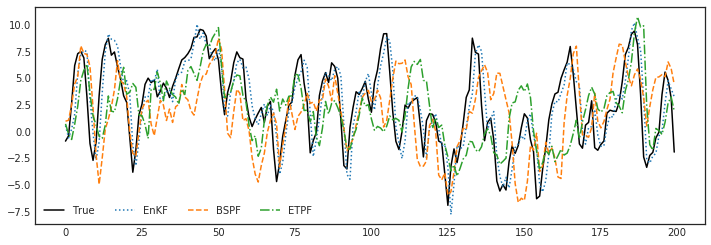

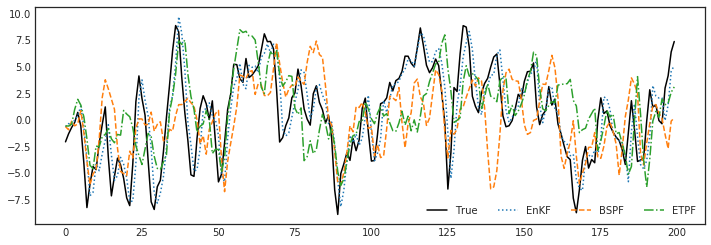

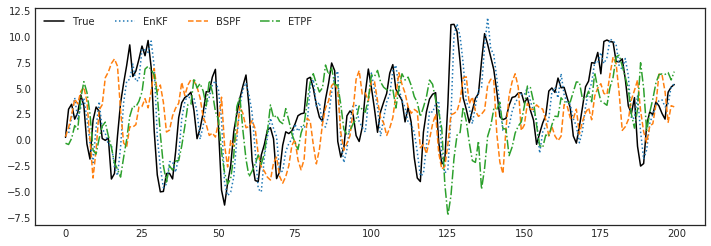

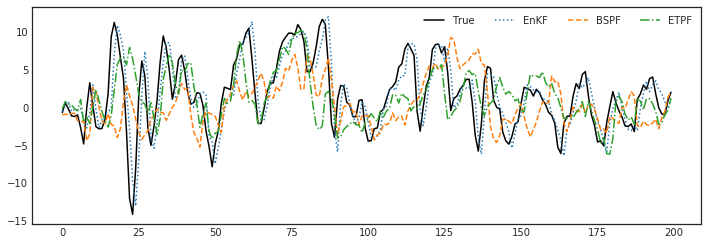

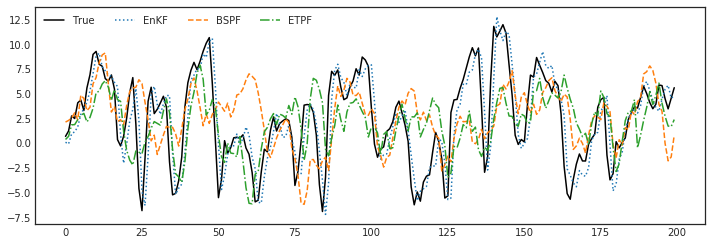

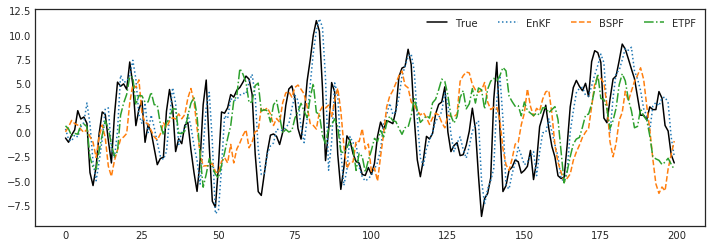

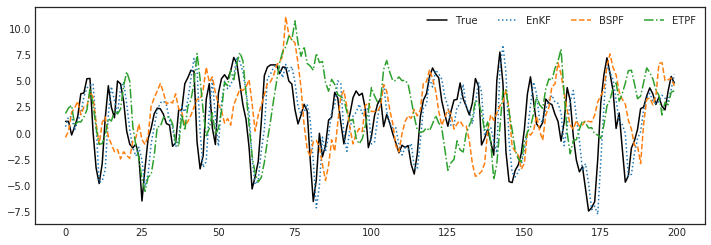

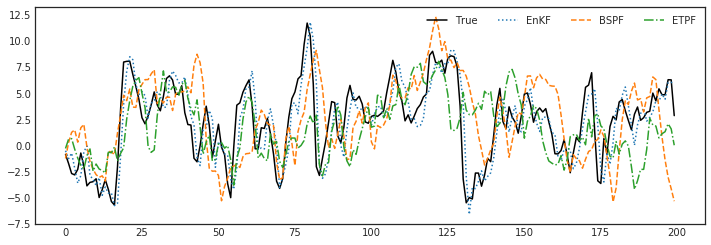

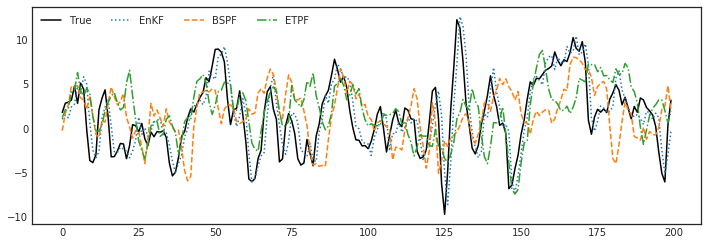

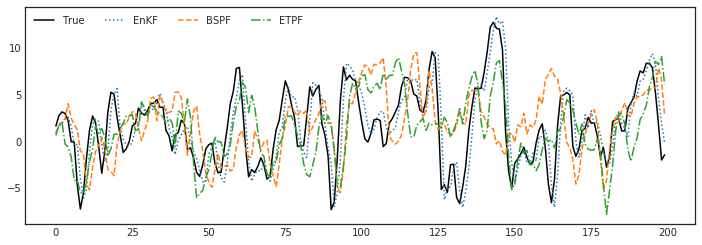

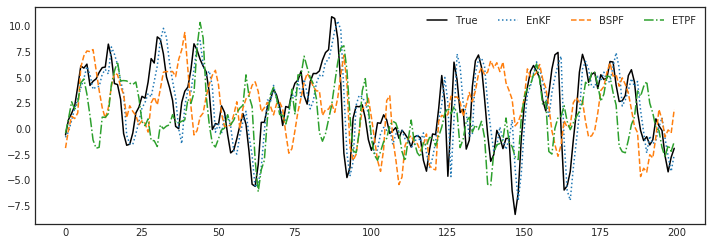

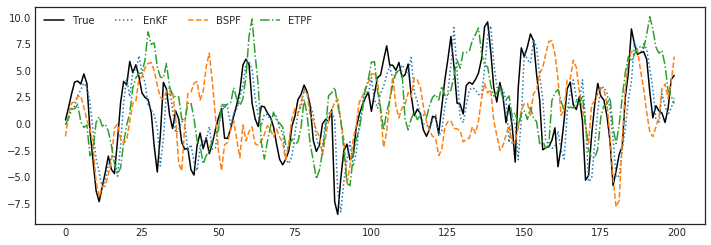

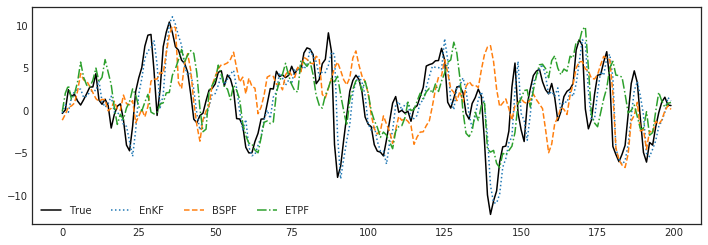

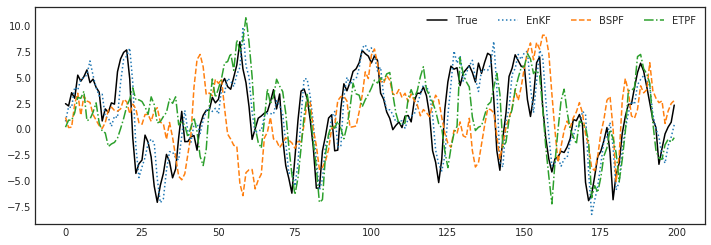

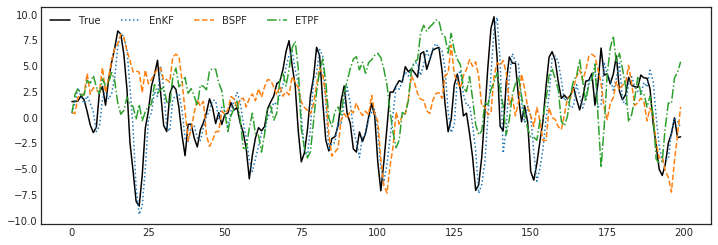

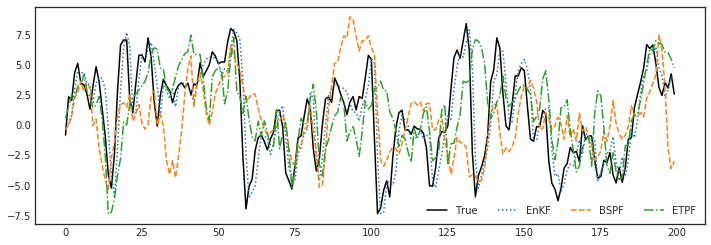

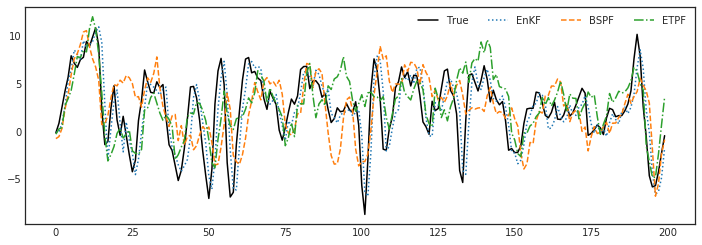

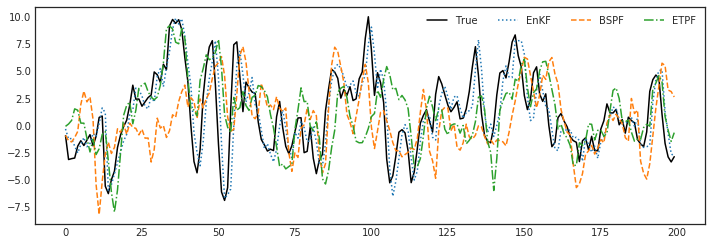

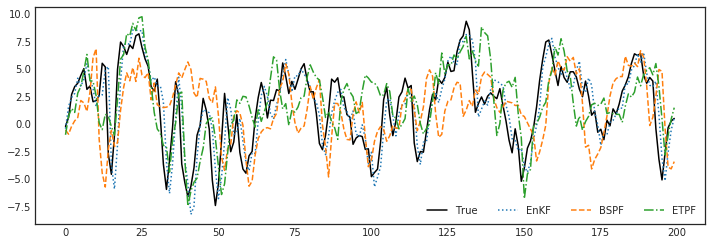

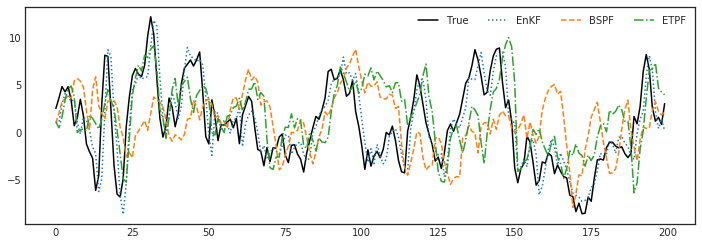

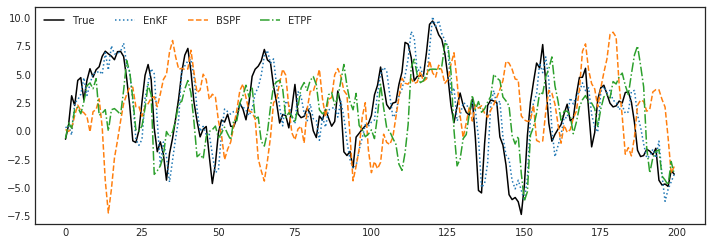

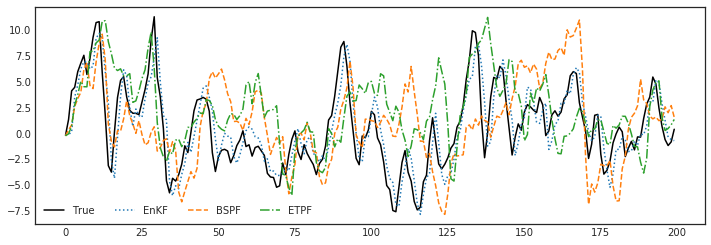

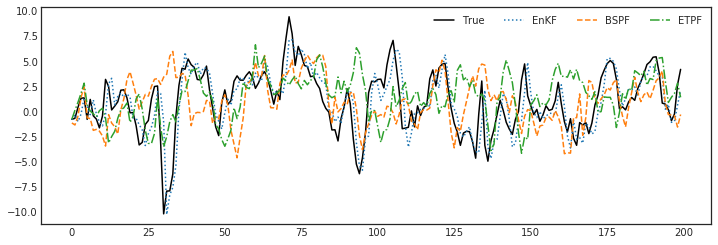

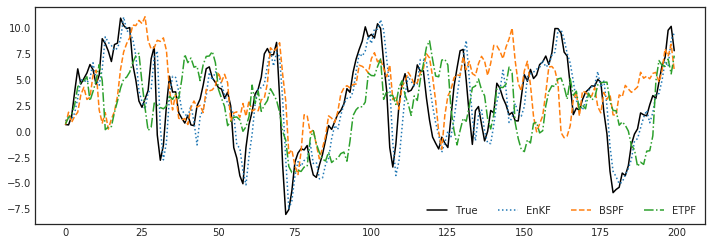

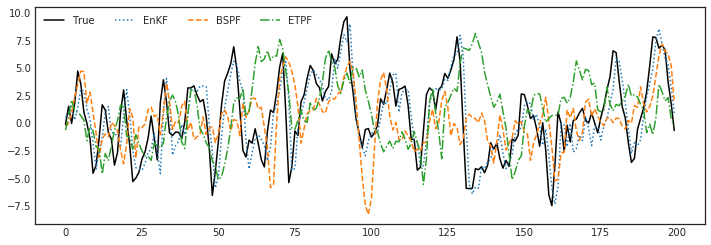

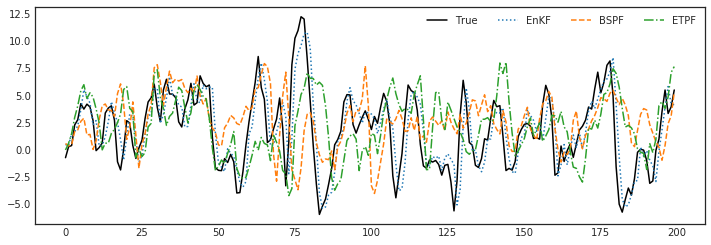

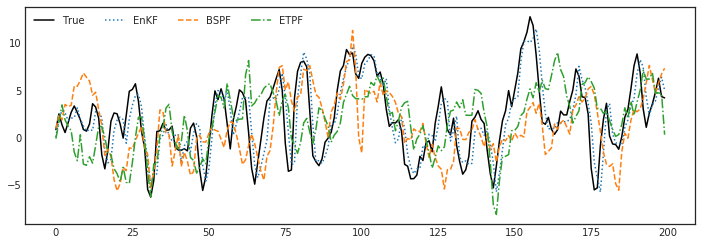

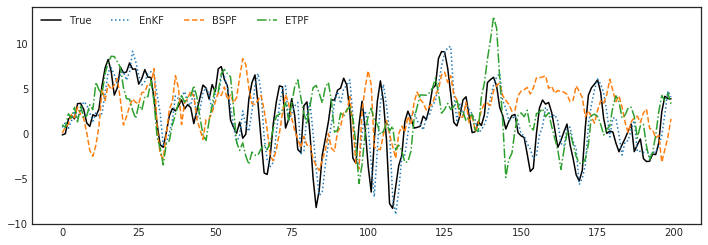

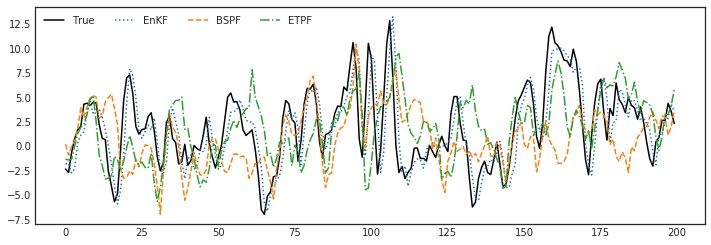

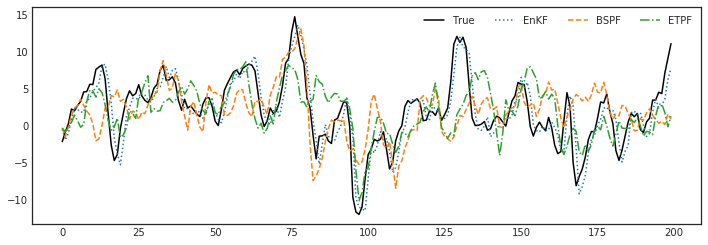

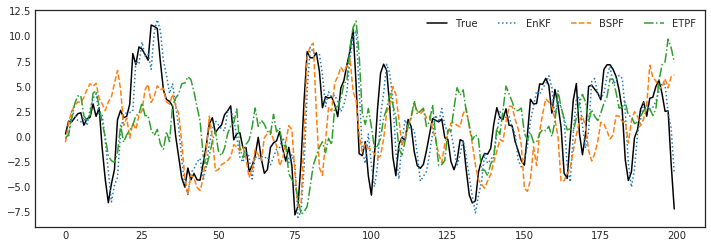

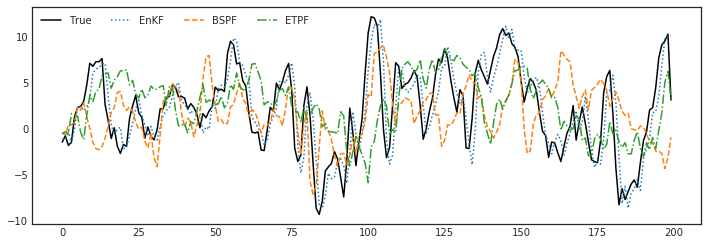

In [15]:
for i in range(z_reference.shape[1]):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(z_reference[:, i], 'k', label='True')
    ax.plot(results_enkf['z_mean_seq'][:, i], ':', label='EnKF')
    ax.plot(results_bspf['z_mean_seq'][:, i], '--', label='BSPF')
    ax.plot(results_etpf['z_mean_seq'][:, i], '-.', label='ETPF')
    ax.legend(ncol=4)